In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/models')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras import layers
from utility import process_md_lines

In [4]:
training_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/training.txt','r',encoding='utf-8').readlines()
testing_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/testing.txt','r',encoding='utf-8').readlines()
validation_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/validation.txt','r',encoding='utf-8').readlines()

In [5]:
training_df = process_md_lines(training_lines)
testing_df = process_md_lines(testing_lines)
validation_df = process_md_lines(validation_lines)

In [6]:
training_df.head()

,id,text,order,total_lines,url,label
0,290,الشريان الأبهر هو أكبر شريان في الجسم وهو ينقل...,0,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
1,290,بشكل عام يكون تضيق الأبهر موجودا لدى المصاب من...,1,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
2,290,وغالبا ما يصاحب تضيق الأبهر عيوب أخرى في القلب...,2,89,https://www.mayoclinic.org/ar/diseases-conditi...,Overview
3,290,تعتمد أعراض تضيق الأبهر على شدة الحالة فمعظم ا...,3,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms
4,290,قد يبدأ ظهور الأعراض على الأطفال المصابين بتضي...,4,89,https://www.mayoclinic.org/ar/diseases-conditi...,Symptoms


In [7]:
tclasses = training_df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [8]:
''' df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7) '''
train_df = training_df
test_df = testing_df

In [39]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_validation = validation_df['text'].to_numpy()

In [40]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()
y_validation = pd.get_dummies(validation_df['label']).to_numpy()

In [11]:
vocab = set()
count = 0
char_count = 0
for text in train_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

for text in test_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [12]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

69150

In [13]:
tokens_lens = [len(sentence.split()) for sentence in train_df['text'].to_numpy()]
SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
SEQ_LENGTH

49

In [14]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [15]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LENGTH)

In [16]:
text_vectorizer.adapt(train_df['text'].to_numpy())

In [17]:
embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [18]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 49)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 49, 128)           8851200   
                                                                 
 bidirectional (Bidirectiona  (None, 49, 128)          98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

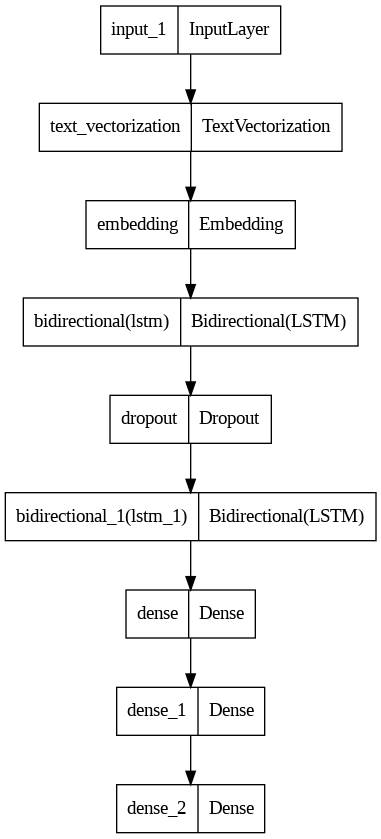

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

In [23]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [24]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[es])

Epoch 1/10
9273/9273 [==============================] - 340s 35ms/step - loss: 0.5175 - accuracy: 0.8273 - val_loss: 0.3278 - val_accuracy: 0.8957
Epoch 2/10
9273/9273 [==============================] - 311s 34ms/step - loss: 0.2286 - accuracy: 0.9279 - val_loss: 0.2109 - val_accuracy: 0.9366
Epoch 3/10
9273/9273 [==============================] - 322s 35ms/step - loss: 0.1362 - accuracy: 0.9566 - val_loss: 0.1691 - val_accuracy: 0.9528
Epoch 4/10
9273/9273 [==============================] - 316s 34ms/step - loss: 0.1003 - accuracy: 0.9674 - val_loss: 0.1508 - val_accuracy: 0.9590
Epoch 5/10
9273/9273 [==============================] - 318s 34ms/step - loss: 0.0826 - accuracy: 0.9727 - val_loss: 0.1447 - val_accuracy: 0.9627
Epoch 6/10
9273/9273 [==============================] - 312s 34ms/step - loss: 0.0714 - accuracy: 0.9758 - val_loss: 0.1328 - val_accuracy: 0.9663
Epoch 7/10
9273/9273 [==============================] - 309s 33ms/step - loss: 0.0639 - accuracy: 0.9780 - val_loss: 0

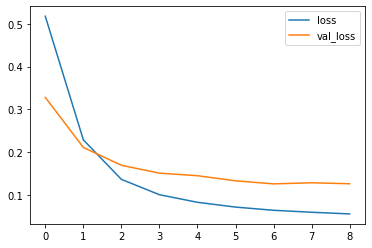

In [25]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [26]:
model.evaluate(test_ds)

1142/1142 [==============================] - 13s 11ms/step - loss: 0.1259 - accuracy: 0.9701


[0.12594082951545715, 0.9701284170150757]

In [27]:
#Test Dataset (10%)
preds = np.argmax(model.predict(X_test), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_test, cat_preds))

1142/1142 [==============================] - 16s 11ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6114
           1       0.98      0.98      0.98      6152
           2       0.97      0.96      0.96      3572
           3       0.94      0.97      0.96      7663
           4       0.99      0.98      0.98     13022

   micro avg       0.97      0.97      0.97     36523
   macro avg       0.97      0.97      0.97     36523
weighted avg       0.97      0.97      0.97     36523
 samples avg       0.97      0.97      0.97     36523



In [42]:
#Validation Dataset ( 10% )
preds_validation = np.argmax(model.predict(X_validation), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds_validation,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_validation, cat_preds))

1149/1149 [==============================] - 14s 12ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6007
           1       0.98      0.98      0.98      5901
           2       0.96      0.94      0.95      3845
           3       0.95      0.97      0.96      7853
           4       0.98      0.98      0.98     13160

   micro avg       0.97      0.97      0.97     36766
   macro avg       0.97      0.96      0.96     36766
weighted avg       0.97      0.97      0.97     36766
 samples avg       0.97      0.97      0.97     36766



In [37]:
r = np.random.randint(0,len(X_train))
text = X_train[r]
true_pred = y_train[r]
print(text)
print(true_pred)
true_pred_ = np.argmax(true_pred)
print(true_pred_)

4 التهاب المفاصل الناجم عن اعتلال الأمعاء enteropathic arthritis

[0 0 0 1 0]
3


In [38]:
myTensor = tf.convert_to_tensor(text, dtype=tf.string) 
myTensor = tf.expand_dims(myTensor,axis=-1)
class_index = np.argmax(model(myTensor))
class_index

3